# User-level analysis of political subreddits

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import statsmodels.api as sm
import sqlite3
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite
from itertools import combinations

import warnings
warnings.filterwarnings('ignore')

from utils import *
from backbone import disparity_filter

## load data

In [2]:
year = 2012
df = build_df_year(year, with_text=True, with_time=False, filter_null=True) # start with yearly analysis
generate_index()

from utils import USERS, SUBREDDITS, user2index, index2user, subr2index, index2subr

building base dataframe for year 2012...
- fetching submissions for year 2012
- fetching comments for year 2012
- number of entries: 5994991


In [3]:
# subsetting
active_user_ls = pd.read_csv(ROOTPATH + "indx/ACTIVEUSERS_ALLYEARS_2_10_100.csv").author.tolist() 
df = df[df["author"].isin(active_user_ls)]

## build network

In [4]:
def build_user_graph(df):
    subm_aggr = df.groupby("submission_id").agg({"author": lambda x: set(list(x))}).reset_index()
    subm_aggr["n_user"] = subm_aggr["author"].map(lambda x: len(x))
    subm_aggr = subm_aggr[subm_aggr["n_user"]>1].reset_index().drop(columns=["index"])  
    
    user_edges = {}
    print("recording edges...")
    # directly writing to nx.Graph() kills the kernel, ugh
    for i,row in subm_aggr.iterrows():
        users = list(row["author"])
        if i%10000==0: print(" - progress:", i/len(subm_aggr))
        userpairs = [*combinations(users,2)]
        for i,up in enumerate(userpairs):
            u1 = min(user2index[up[0]],user2index[up[1]])
            u2 = max(user2index[up[0]],user2index[up[1]])
            try:
                user_edges[(u1, u2)] += 1
            except:
                user_edges[(u1, u2)] = 1
                
    print("building graph...")       
    userg = nx.Graph()
    for p,w in user_edges.items():
        userg.add_edge(p[0], p[1], weight=w)
    
    print("graph descriptives:")
    print(" - # of nodes:", len(userg.nodes()))
    print(" - # of edges:", len(userg.edges()))
    return user_edges, userg

In [5]:
user_edges, userg = build_user_graph(df)  # should take a while

recording edges...
 - progress: 0.0
 - progress: 0.0645619471883272
 - progress: 0.1291238943766544
 - progress: 0.1936858415649816
 - progress: 0.2582477887533088
 - progress: 0.322809735941636
 - progress: 0.3873716831299632
 - progress: 0.4519336303182904
 - progress: 0.5164955775066176
 - progress: 0.5810575246949448
 - progress: 0.645619471883272
 - progress: 0.7101814190715992
 - progress: 0.7747433662599263
 - progress: 0.8393053134482537
 - progress: 0.9038672606365808
 - progress: 0.968429207824908
building graph...
graph descriptives:
 - # of nodes: 14752
 - # of edges: 23699706


In [6]:
# nx.write_gpickle(userg, ROOTPATH + f"output/user_graph_{year}.gpickle")

## degree and strength distribution

In [7]:
degs = list(dict(userg.degree()).values())
strs = list(dict(userg.degree(weight="weight")).values())

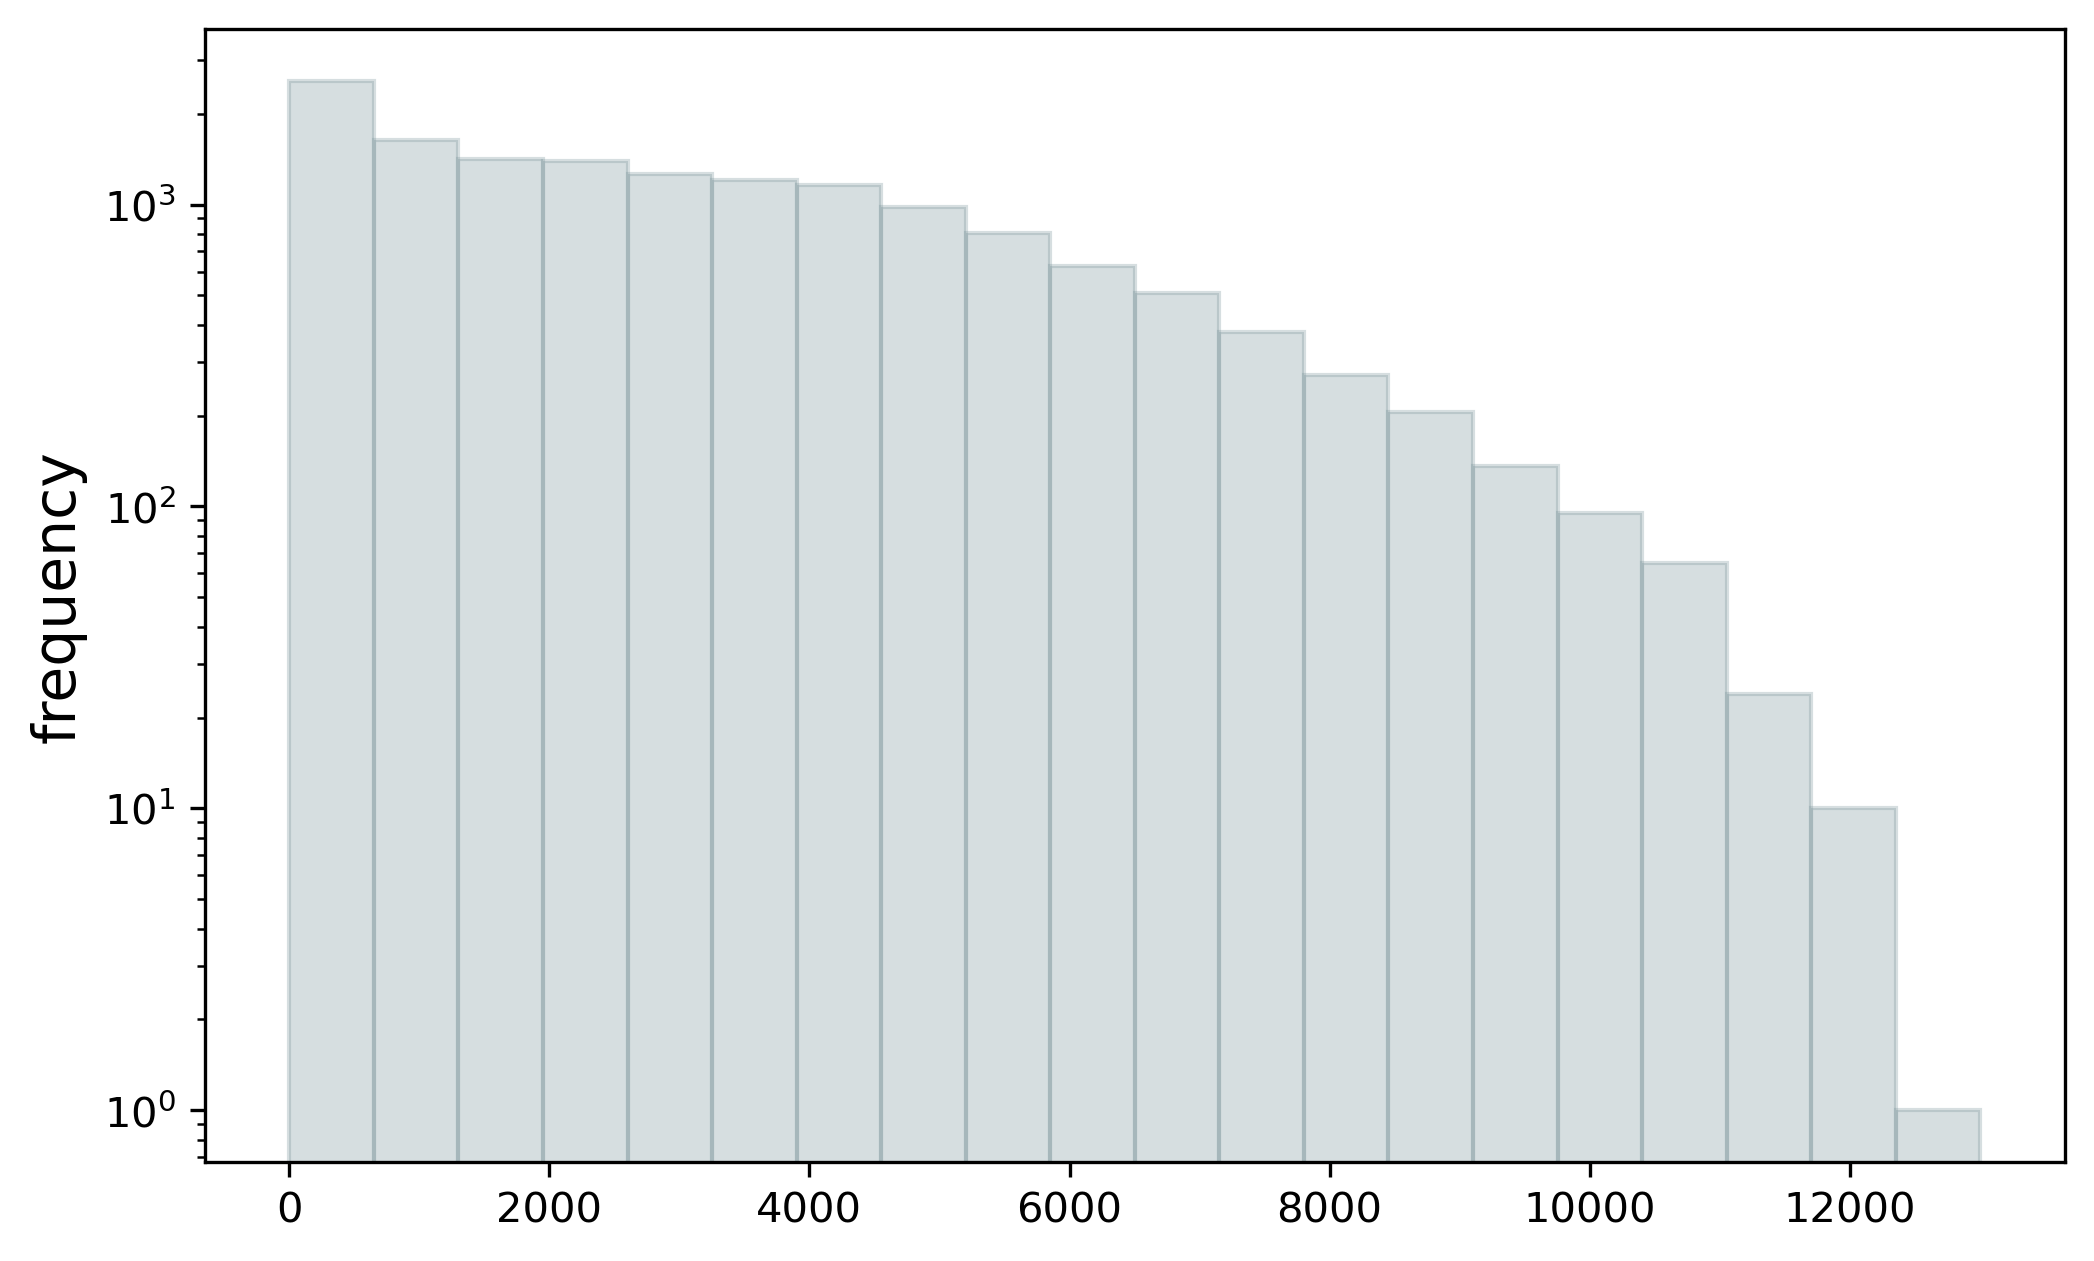

In [8]:
fig,ax = plt.subplots(figsize=(8,5), dpi=300)
plt.hist(degs, bins=20, edgecolor="#7A9299", color="#7A9299", alpha=0.3)
plt.yscale("log")
# plt.xlabel("strength", fontsize=14)
plt.ylabel("frequency", fontsize=14)
plt.savefig(ROOTPATH + f"output/fig/user_strength_{year}.png", dpi=300)

## toxicity level and strength

In [9]:
nodedf = pd.DataFrame()
nodedf["Id"] = [*userg.nodes()]
nodedf["author"] = nodedf["Id"].map(lambda x: index2user[x])
nodedf["degree"] = degs
nodedf["strength"] = strs
nodedf["strength_logged"] = nodedf["strength"].map(lambda x: np.log(x))
nodedf["degree_logged"] = nodedf["degree"].map(lambda x: np.log(x))

In [10]:
# get toxicity score for individual users
aggr_func = {"toxicity": lambda x: list(x)}
user_toxicity = df[["author","toxicity"]][df["toxicity"].notna()].groupby("author").agg(aggr_func).reset_index()
nodedf = nodedf.merge(user_toxicity, on="author", how="left")

nodedf["mean_tox"] = nodedf["toxicity"].map(lambda x: np.mean(x))
nodedf["max_tox"] = nodedf["toxicity"].map(lambda x: max(x) if str(x)!="nan" else np.NaN)
nodedf["min_tox"] = nodedf["toxicity"].map(lambda x: min(x) if str(x)!="nan" else np.NaN)
nodedf["range_tox"] = nodedf["toxicity"].map(lambda x: max(x)-min(x) if str(x)!="nan" else np.NaN)
nodedf["var_tox"] = nodedf["toxicity"].map(lambda x: np.var(x) if str(x)!="nan" else np.NaN)

In [84]:
# fig, ax = plt.subplots(ncols=3, figsize=(14,4), sharex=True, sharey=True, dpi=300)
# for i,col in enumerate(["mean_tox", "max_tox", "min_tox"]):
#     filtered_df = nodedf.dropna(subset=["strength_logged", col])
# #     filtered_df = nodedf.dropna(subset=["degree_logged", col])
#     x = filtered_df["strength_logged"]
#     y = filtered_df[col]

#     # scatterplot
#     _ = ax[i].scatter(x, y, cmap="Reds", c=filtered_df["var_tox"], alpha=0.6, s=1, marker="+")
    
#     # OLS
#     m,b = np.polyfit(x, y, 1)
#     ax[i].plot(x, m*x+b, ":", color="#7A9299")
#     ax[i].set_xlabel("strength (logged)", fontsize=14)
#     ax[i].set_ylabel(col, fontsize=14)
# fig.colorbar(_, cax=fig.add_axes([0.93, 0.15, 0.01, 0.7]), label="variance")
# plt.savefig(ROOTPATH + f"output/fig/user_strength_tox_{year}.png", dpi=300)

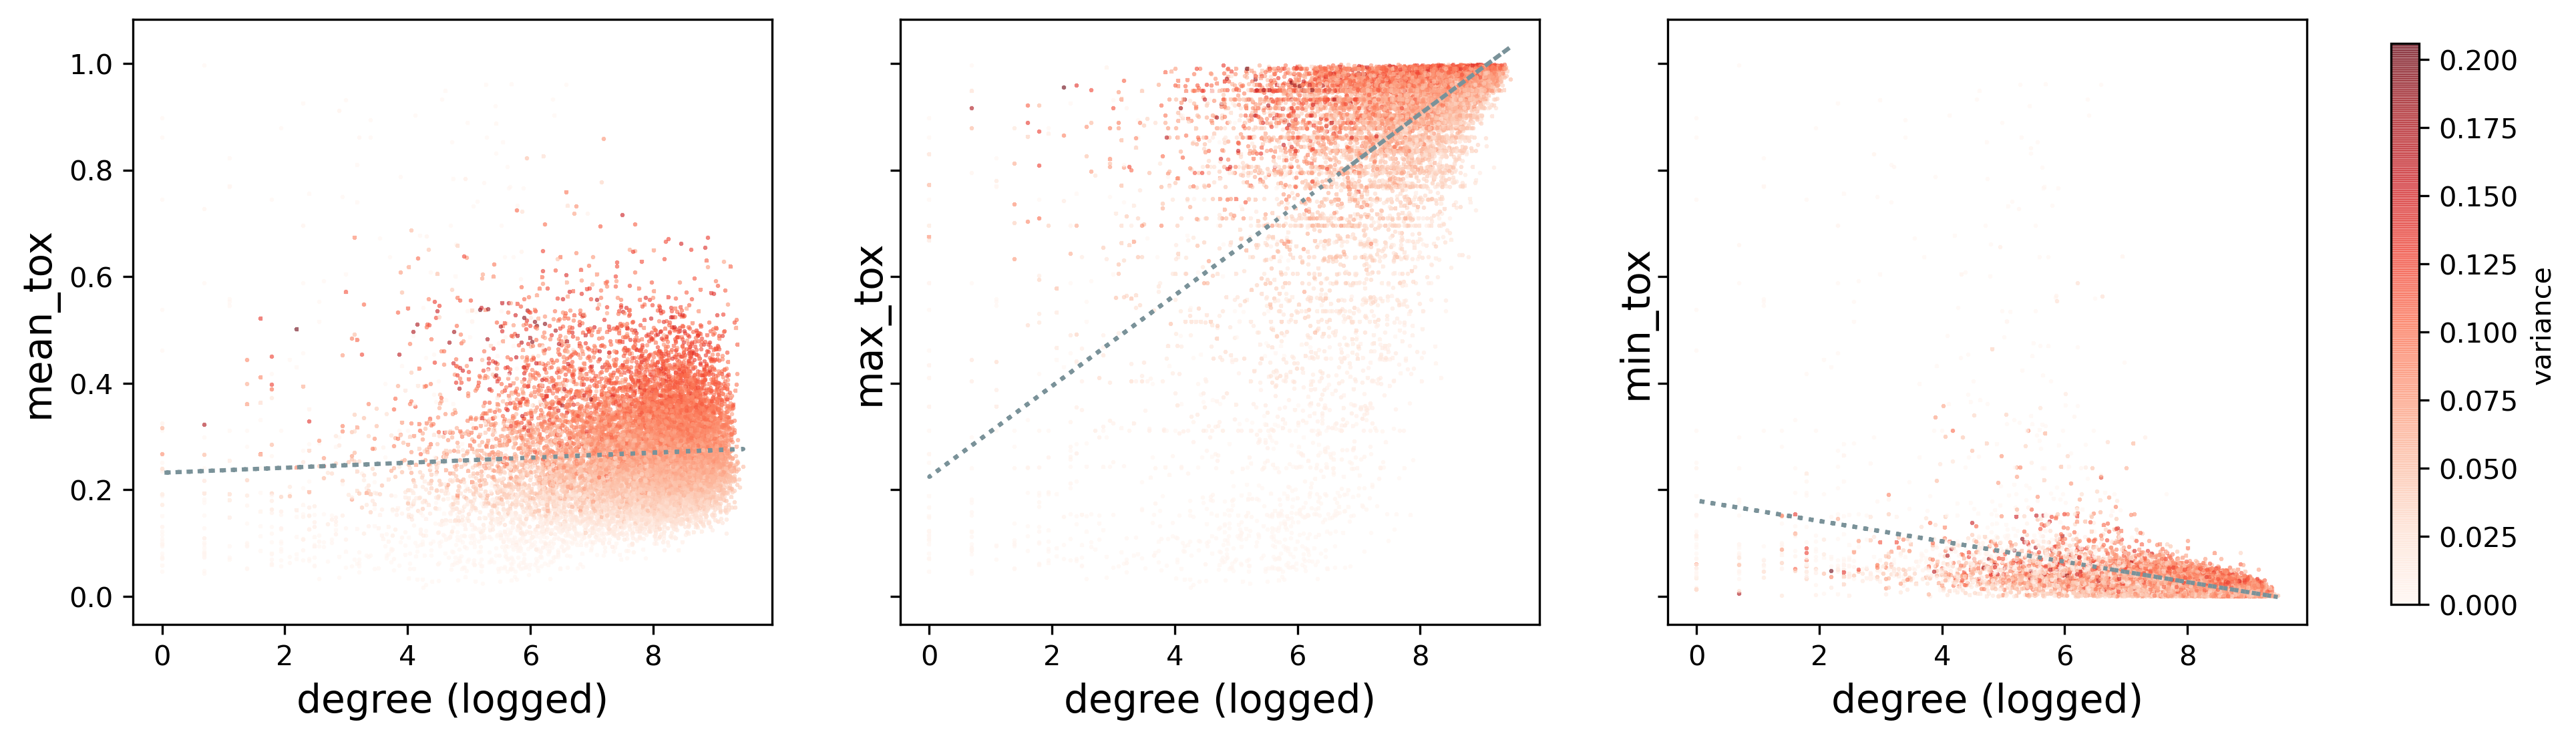

In [85]:
fig, ax = plt.subplots(ncols=3, figsize=(14,4), sharex=True, sharey=True, dpi=300)
for i,col in enumerate(["mean_tox", "max_tox", "min_tox"]):
    filtered_df = nodedf.dropna(subset=["degree_logged", col])
    x = filtered_df["degree_logged"]
    y = filtered_df[col]

    # scatterplot
    _ = ax[i].scatter(x, y, cmap="Reds", c=filtered_df["var_tox"], alpha=0.6, s=1, marker="+")
    
    # OLS
    m,b = np.polyfit(x, y, 1)
    ax[i].plot(x, m*x+b, ":", color="#7A9299")
    ax[i].set_xlabel("degree (logged)", fontsize=14)
    ax[i].set_ylabel(col, fontsize=14)
fig.colorbar(_, cax=fig.add_axes([0.93, 0.15, 0.01, 0.7]), label="variance")
plt.savefig(ROOTPATH + f"output/fig/user_degree_tox_{year}.png", dpi=300)

In [13]:
import scipy.stats
filtered_df = nodedf.dropna(subset=["degree", "strength", "mean_tox"])
x = filtered_df["strength"]
y = filtered_df["mean_tox"]
scipy.stats.pearsonr(x, y)

(0.05629184551172168, 7.902396018295261e-12)

In [14]:
x = filtered_df["degree"]
y = filtered_df["mean_tox"]
scipy.stats.pearsonr(x, y)

(0.06576015823720108, 1.3151779767474559e-15)

### OLS fitness?

In [15]:
def OLS_fit(x,y):
    x = sm.add_constant(x)
    model = sm.OLS(y,x)
    results = model.fit()
    print(results.params)
    print(print(results.summary()))

In [86]:
for col in ["mean_tox", "max_tox", "min_tox"]:
    print("\n\n********* OLS *********")
    print("x = degree")
    print("y =", col, "\n")
    OLS_fit(nodedf.dropna()["degree_logged"], nodedf.dropna()[col])



********* OLS *********
x = degree
y = mean_tox 

const            0.231830
degree_logged    0.004709
dtype: float64
                            OLS Regression Results                            
Dep. Variable:               mean_tox   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     62.59
Date:                Wed, 08 Dec 2021   Prob (F-statistic):           2.73e-15
Time:                        11:07:04   Log-Likelihood:                 13046.
No. Observations:               14745   AIC:                        -2.609e+04
Df Residuals:                   14743   BIC:                        -2.607e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------

## static TFP

Are my neighbors are on average more toxic than me?

### network level

In [66]:
xnn = 0
for k,x in zip(nodedf.dropna()["degree"],nodedf.dropna()["mean_tox"]):
    xnn += k*x
xnn = xnn/(sum(nodedf.dropna()["degree"]))
print("<xnn>:", xnn)
print("<x>:",np.mean(nodedf.dropna()["mean_tox"]))

<xnn>: 0.2724491469160079
<x>: 0.2673546655740431


### node level

In [17]:
TOXICITY_DICT = nodedf[["Id","mean_tox"]].set_index("Id").to_dict()["mean_tox"]

In [71]:
def examine_gfps(g, nodedf):
    gfps = []
    for i,(n,v) in enumerate(TOXICITY_DICT.items()):
        if i%1000==0: print("progress:", i/len(TOXICITY_DICT))
        neighbors = g[n]
        my_tox = v
        g.nodes[n]["mean_tox"] = v
        env_tox = np.mean([TOXICITY_DICT[x] for x in neighbors])
        if my_tox > env_tox:  # I'm more toxic than my neighbors
            gfps.append(0)
        else:  # my neighbors are more toxic than me
            gfps.append(1)
    nodedf["gfp"] = gfps

In [72]:
examine_gfps(userg, nodedf)

progress: 0.0
progress: 0.06778741865509762
progress: 0.13557483731019523
progress: 0.20336225596529284
progress: 0.27114967462039047
progress: 0.33893709327548804
progress: 0.4067245119305857
progress: 0.4745119305856833
progress: 0.5422993492407809
progress: 0.6100867678958786
progress: 0.6778741865509761
progress: 0.7456616052060737
progress: 0.8134490238611713
progress: 0.881236442516269
progress: 0.9490238611713666


In [69]:
# average toxicity holding prob
print("H:", np.mean(nodedf["gfp"]))

H: 0.6170010845986985


In [74]:
# assortativity of toxicity  # should take a while
print("rxx:", nx.attribute_assortativity_coefficient(userg, "mean_tox"))

rxx: -0.00010844905890547219


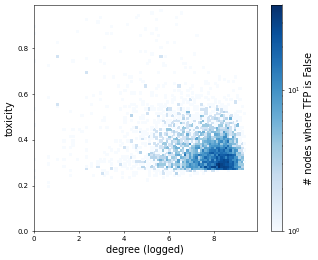

In [75]:
import matplotlib as mpl
fig, ax = plt.subplots(figsize=(7.2,6), dpi=50)
x = nodedf[nodedf["gfp"]==0].dropna()["degree_logged"]
y = nodedf[nodedf["gfp"]==0].dropna()["mean_tox"]
# ax.set_ylim(0,1)
# ax.set_xlim(2,12)
arrs1 = plt.hist2d(x, y, 
                   bins=[np.arange(0,10,10/100), np.arange(0,1,1/100)],
           norm=mpl.colors.LogNorm(),
           cmap="Blues")
plt.xlabel("degree (logged)", fontsize=14)
plt.ylabel("toxicity", fontsize=14)
plt.colorbar().set_label(label="# nodes where TFP is False",size=14)
plt.savefig(ROOTPATH + f"output/fig/tfp_false_{year}.png", dpi=300)

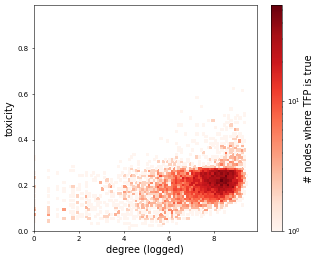

In [76]:
import matplotlib as mpl
fig, ax = plt.subplots(figsize=(7.2,6), dpi=50)
x2 = nodedf[nodedf["gfp"]==1].dropna()["degree_logged"]
y2 = nodedf[nodedf["gfp"]==1].dropna()["mean_tox"]
# ax.set_ylim(0,1)
# ax.set_xlim(2,12)
arrs2 = plt.hist2d(x2, y2,
                   bins=[np.arange(0,10,10/100), np.arange(0,1,1/100)],
           norm=mpl.colors.LogNorm(),
           cmap="Reds")
plt.xlabel("degree (logged)", fontsize=14)
plt.ylabel("toxicity", fontsize=14)
plt.colorbar().set_label(label="# nodes where TFP is true",size=14)
plt.savefig(ROOTPATH + f"output/fig/tfp_true_{year}.png", dpi=300)

In [51]:
# check hist2d output
def rotate_90_degree_anticlckwise(matrix):
    new_matrix = []
    for i in range(len(matrix[0]), 0, -1):
        new_matrix.append(list(map(lambda x: x[i-1], matrix)))
    return new_matrix

# plt.imshow(rotate_90_degree_anticlckwise(arrs1[0]), cmap="Reds", norm=mpl.colors.LogNorm())
# plt.imshow(rotate_90_degree_anticlckwise(arrs2[0]), cmap="Reds", norm=mpl.colors.LogNorm())

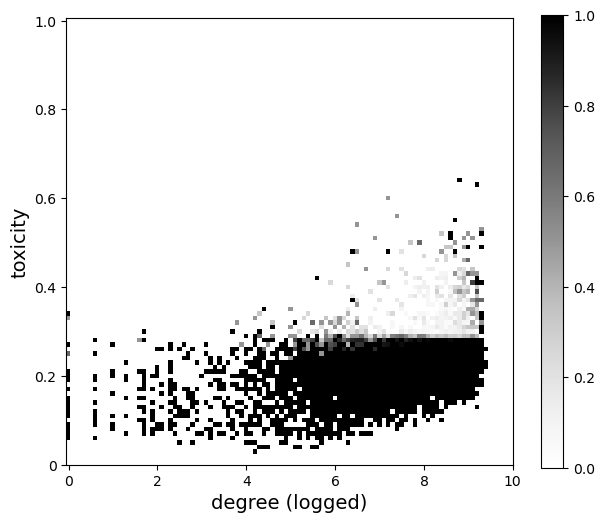

In [146]:
arrs_d = arrs2[0]/(arrs2[0]+arrs1[0])
fig, ax = plt.subplots(figsize=(7.2,6), dpi=100)
plt.imshow(rotate_90_degree_anticlckwise(arrs_d), cmap="Greys")
plt.xticks(np.arange(0,120,20), [0,2,4,6,8,10])
plt.yticks(np.arange(0,120,20), [1.0, 0.8, 0.6, 0.4, 0.2, 0])
plt.xlabel("degree (logged)", fontsize=14)
plt.ylabel("toxicity", fontsize=14)
plt.colorbar()
plt.savefig(ROOTPATH + f"output/fig/tfp_prob_{year}.png", dpi=300)

## compare against null

### shuffling toxicity scores per post

In [24]:
df_rd_tox = df.copy()
df_rd_tox["toxicity"] = np.random.permutation(df_rd_tox["toxicity"])

In [25]:
user_edges_rd_tox, userg_rd_tox = build_user_graph(df_rd_tox)

recording edges...
 - progress: 0.0
 - progress: 0.0645619471883272
 - progress: 0.1291238943766544
 - progress: 0.1936858415649816
 - progress: 0.2582477887533088
 - progress: 0.322809735941636
 - progress: 0.3873716831299632
 - progress: 0.4519336303182904
 - progress: 0.5164955775066176
 - progress: 0.5810575246949448
 - progress: 0.645619471883272
 - progress: 0.7101814190715992
 - progress: 0.7747433662599263
 - progress: 0.8393053134482537
 - progress: 0.9038672606365808
 - progress: 0.968429207824908
building graph...
graph descriptives:
 - # of nodes: 14752
 - # of edges: 23699706


In [26]:
degs_rd_tox = list(dict(userg_rd_tox.degree()).values())
strs_rd_tox = list(dict(userg_rd_tox.degree(weight="weight")).values())

In [27]:
nodedf_rd_tox = pd.DataFrame()
nodedf_rd_tox["Id"] = [*userg_rd_tox.nodes()]
nodedf_rd_tox["author"] = nodedf_rd_tox["Id"].map(lambda x: index2user[x])
nodedf_rd_tox["degree"] = degs_rd_tox
nodedf_rd_tox["strength"] = strs_rd_tox
nodedf_rd_tox["strength_logged"] = nodedf_rd_tox["strength"].map(lambda x: np.log(x))
nodedf_rd_tox["degree_logged"] = nodedf_rd_tox["degree"].map(lambda x: np.log(x))

In [28]:
# get toxicity score for individual users
aggr_func = {"toxicity": lambda x: list(x)}
user_toxicity_rd_tox = df_rd_tox[["author","toxicity"]][df_rd_tox["toxicity"].notna()].groupby("author").agg(aggr_func).reset_index()
nodedf_rd_tox = nodedf_rd_tox.merge(user_toxicity_rd_tox, on="author", how="left")

nodedf_rd_tox["mean_tox"] = nodedf_rd_tox["toxicity"].map(lambda x: np.mean(x))
nodedf_rd_tox["max_tox"] = nodedf_rd_tox["toxicity"].map(lambda x: max(x) if str(x)!="nan" else np.NaN)
nodedf_rd_tox["min_tox"] = nodedf_rd_tox["toxicity"].map(lambda x: min(x) if str(x)!="nan" else np.NaN)
nodedf_rd_tox["range_tox"] = nodedf_rd_tox["toxicity"].map(lambda x: max(x)-min(x) if str(x)!="nan" else np.NaN)
nodedf_rd_tox["var_tox"] = nodedf_rd_tox["toxicity"].map(lambda x: np.var(x) if str(x)!="nan" else np.NaN)

In [78]:
# network level paradox
xnn = 0
for k,x in zip(nodedf_rd_tox.dropna()["degree"],nodedf_rd_tox.dropna()["mean_tox"]):
    xnn += k*x
xnn = xnn/(sum(nodedf_rd_tox.dropna()["degree"]))
print("<xnn>:", xnn)
print("<x>:",np.mean(nodedf_rd_tox.dropna()["mean_tox"]))

<xnn>: 0.26715696572734354
<x>: 0.26733346174619693


In [81]:
# fig, ax = plt.subplots(ncols=3, figsize=(14,4), sharex=True, sharey=True, dpi=300)
# for i,col in enumerate(["mean_tox", "max_tox", "min_tox"]):
#     filtered_df = nodedf_rd_tox.dropna(subset=["strength_logged", col])
# #     filtered_df = nodedf.dropna(subset=["degree_logged", col])
#     x = filtered_df["strength_logged"]
#     y = filtered_df[col]

#     # scatterplot
#     _ = ax[i].scatter(x, y, cmap="Greys", c=filtered_df["var_tox"], alpha=0.6, s=1, marker="+")
    
#     # OLS
#     m,b = np.polyfit(x, y, 1)
#     ax[i].plot(x, m*x+b, ":", color="#0079D3")
#     ax[i].set_xlabel("strength (logged)", fontsize=14)
#     ax[i].set_ylabel(col, fontsize=14)
#     ax[i].set_ylim(-0.1,1.1)
# fig.colorbar(_, cax=fig.add_axes([0.93, 0.15, 0.01, 0.7]), label="variance")
# plt.savefig(ROOTPATH + f"output/fig/rd_tox_user_strength_tox_{year}.png", dpi=300)

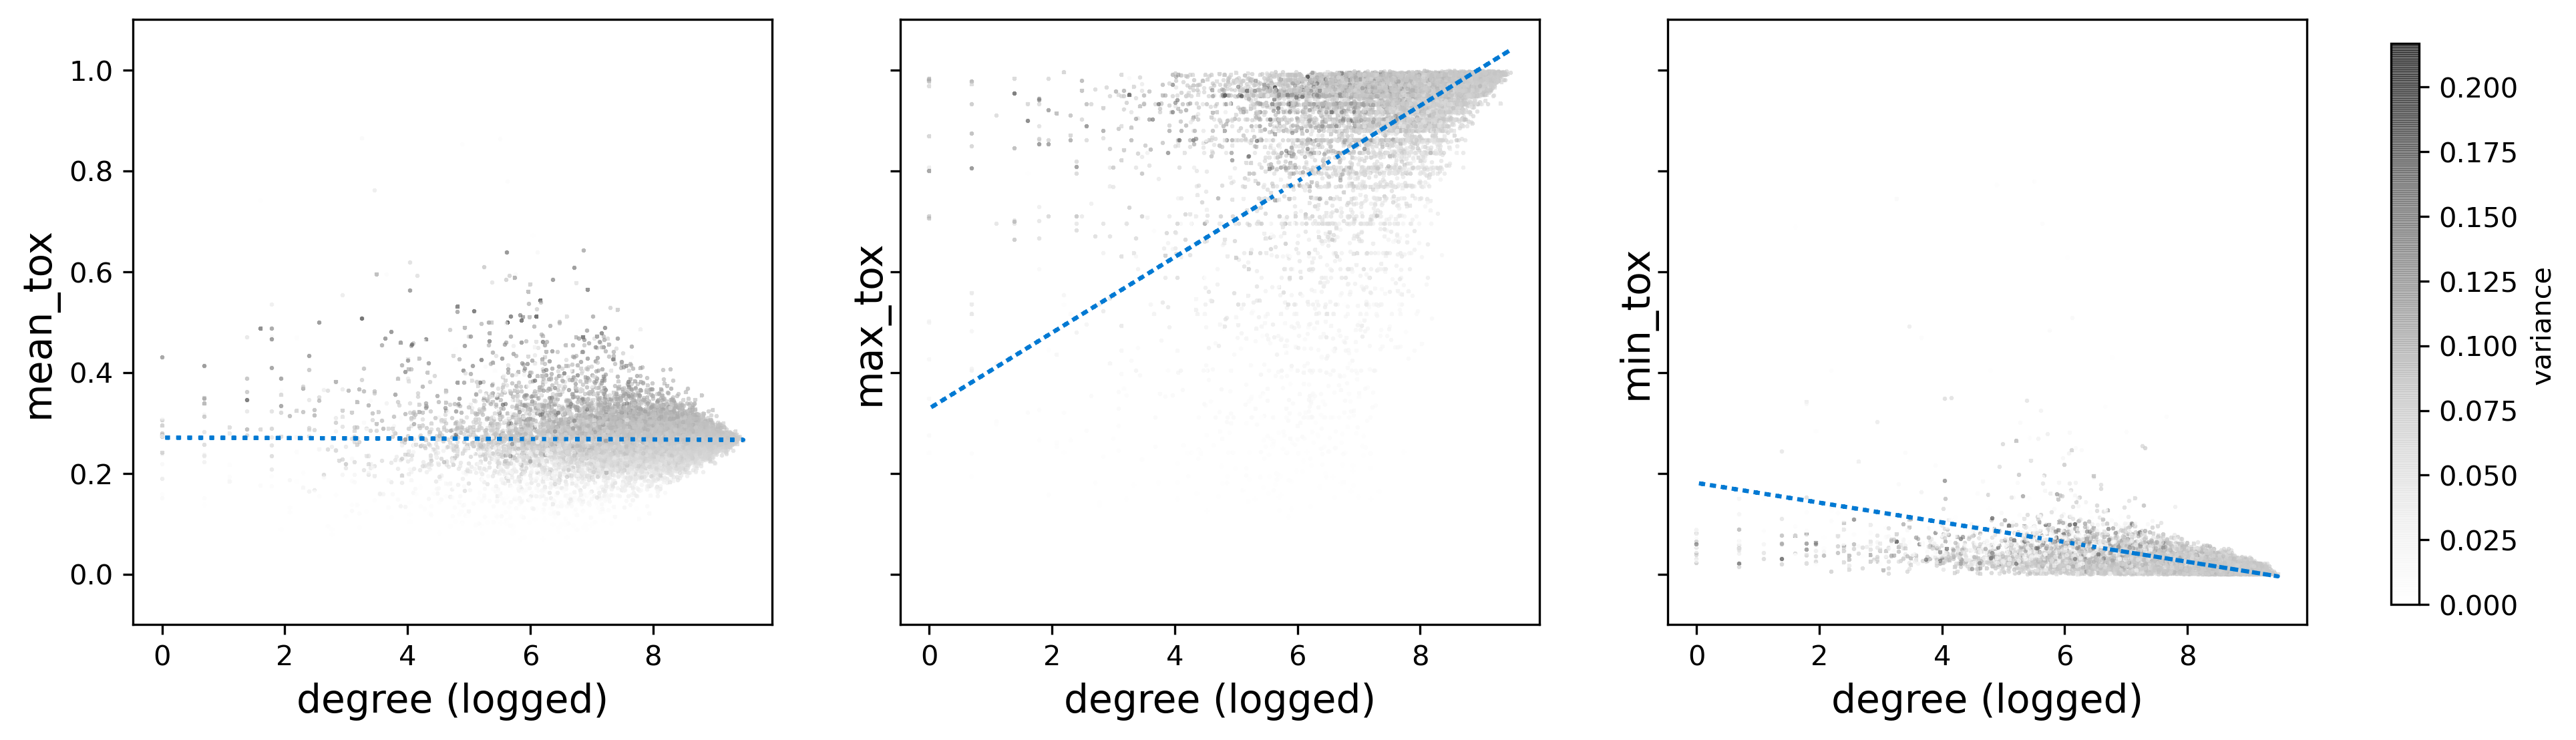

In [82]:
fig, ax = plt.subplots(ncols=3, figsize=(14,4), sharex=True, sharey=True, dpi=300)
for i,col in enumerate(["mean_tox", "max_tox", "min_tox"]):
    filtered_df = nodedf_rd_tox.dropna(subset=["degree_logged", col])
    x = filtered_df["degree_logged"]
    y = filtered_df[col]

    # scatterplot
    _ = ax[i].scatter(x, y, cmap="Greys", c=filtered_df["var_tox"], alpha=0.6, s=1, marker="+")
    
    # OLS
    m,b = np.polyfit(x, y, 1)
    ax[i].plot(x, m*x+b, ":", color="#0079D3")
    ax[i].set_xlabel("degree (logged)", fontsize=14)
    ax[i].set_ylabel(col, fontsize=14)
    ax[i].set_ylim(-0.1,1.1)
fig.colorbar(_, cax=fig.add_axes([0.93, 0.15, 0.01, 0.7]), label="variance")
plt.savefig(ROOTPATH + f"output/fig/rd_tox_user_degree_tox_{year}.png", dpi=300)

In [83]:
for col in ["mean_tox", "max_tox", "min_tox"]:
    print("\n\n********* OLS *********")
    print("x = degree")
    print("y =", col, "\n")
    OLS_fit(nodedf_rd_tox.dropna()["degree_logged"], nodedf_rd_tox.dropna()[col])



********* OLS *********
x = degree
y = mean_tox 

const            0.270829
degree_logged   -0.000463
dtype: float64
                            OLS Regression Results                            
Dep. Variable:               mean_tox   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.413
Date:                Wed, 08 Dec 2021   Prob (F-statistic):              0.235
Time:                        11:03:22   Log-Likelihood:                 19282.
No. Observations:               14747   AIC:                        -3.856e+04
Df Residuals:                   14745   BIC:                        -3.855e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------

In [80]:
import scipy.stats
filtered_df = nodedf_rd_tox.dropna(subset=["degree", "strength", "mean_tox"])
x = filtered_df["strength"]
y = filtered_df["mean_tox"]
scipy.stats.pearsonr(x, y)

(-0.002136747054382053, 0.7952811608252172)

In [79]:
x = filtered_df["degree"]
y = filtered_df["mean_tox"]
scipy.stats.pearsonr(x, y)

(-0.012114292529581835, 0.14120871597962475)

In [34]:
TOXICITY_DICT_RD_TOX = nodedf_rd_tox[["Id","mean_tox"]].set_index("Id").to_dict()["mean_tox"]

In [108]:
examine_gfps(userg_rd_tox, nodedf_rd_tox)

progress: 0.0
progress: 0.06778741865509762
progress: 0.13557483731019523
progress: 0.20336225596529284
progress: 0.27114967462039047
progress: 0.33893709327548804
progress: 0.4067245119305857
progress: 0.4745119305856833
progress: 0.5422993492407809
progress: 0.6100867678958786
progress: 0.6778741865509761
progress: 0.7456616052060737
progress: 0.8134490238611713
progress: 0.881236442516269
progress: 0.9490238611713666


In [109]:
# average toxicity holding prob
print("H:", np.mean(nodedf_rd_tox["gfp"]))

H: 0.6170010845986985


In [110]:
# assortativity of toxicity  # should take a while
print("rxx:", nx.attribute_assortativity_coefficient(userg_rd_tox, "mean_tox"))

rxx: -0.00010844905890547219


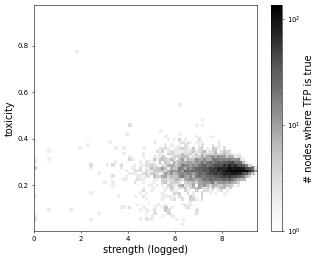

In [142]:
fig, ax = plt.subplots(figsize=(7.2,6), dpi=50)
x = nodedf_rd_tox[nodedf_rd_tox["gfp"]==1].dropna()["degree_logged"]
y = nodedf_rd_tox[nodedf_rd_tox["gfp"]==1].dropna()["mean_tox"]
arrs3 = plt.hist2d(x, y, (80,80), norm=mpl.colors.LogNorm(), cmap="Greys")
plt.xlabel("strength (logged)", fontsize=14)
plt.ylabel("toxicity", fontsize=14)
# ax.set_ylim(0,0.6)
plt.colorbar().set_label(label="# nodes where TFP is true",size=14)
plt.savefig(ROOTPATH + f"output/fig/rd_tox_tfp_true_{year}.png", dpi=300)

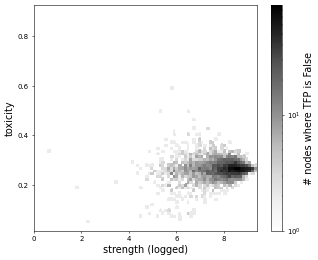

In [143]:
fig, ax = plt.subplots(figsize=(7.2,6), dpi=50)
x = nodedf_rd_tox[nodedf_rd_tox["gfp"]==0].dropna()["degree_logged"]
y = nodedf_rd_tox[nodedf_rd_tox["gfp"]==0].dropna()["mean_tox"]
arrs4 = plt.hist2d(x, y, (80,80), norm=mpl.colors.LogNorm(), cmap="Greys")
plt.xlabel("strength (logged)", fontsize=14)
plt.ylabel("toxicity", fontsize=14)
# ax.set_ylim(0,0.6)
plt.colorbar().set_label(label="# nodes where TFP is False",size=14)
plt.savefig(ROOTPATH + f"output/fig/rd_tox_tfp_false_{year}.png", dpi=300)

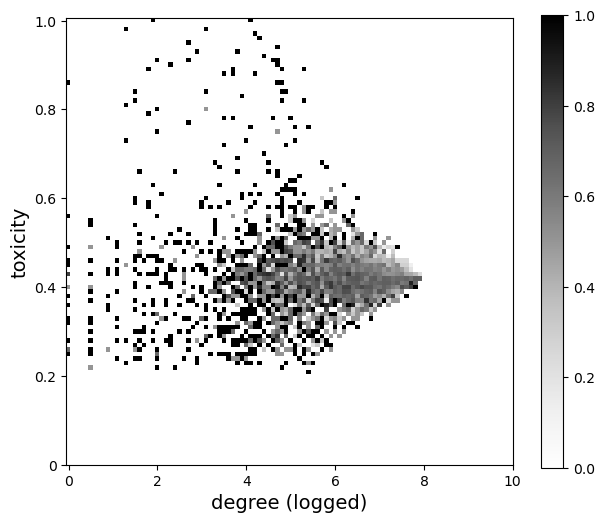

In [145]:
arrs_d2 = arrs3[0]/(arrs3[0]+arrs4[0])
fig, ax = plt.subplots(figsize=(7.2,6), dpi=100)
plt.imshow(rotate_90_degree_anticlckwise(arrs_d2), cmap="Greys")
plt.xticks(np.arange(0,120,20), [0,2,4,6,8,10])
plt.yticks(np.arange(0,120,20), [1.0, 0.8, 0.6, 0.4, 0.2, 0])
plt.xlabel("degree (logged)", fontsize=14)
plt.ylabel("toxicity", fontsize=14)
plt.colorbar()
plt.savefig(ROOTPATH + f"output/fig/rd_tfp_prob_{year}.png", dpi=300)

### shuffling toxicity scores per user

In [100]:
nodedf_rd_tox3 = nodedf.copy()
nodedf_rd_tox3[["mean_tox",
                "max_tox",
                "min_tox"]] = np.random.permutation(nodedf_rd_tox3[["mean_tox",
                                                                    "max_tox",
                                                                    "min_tox"]])

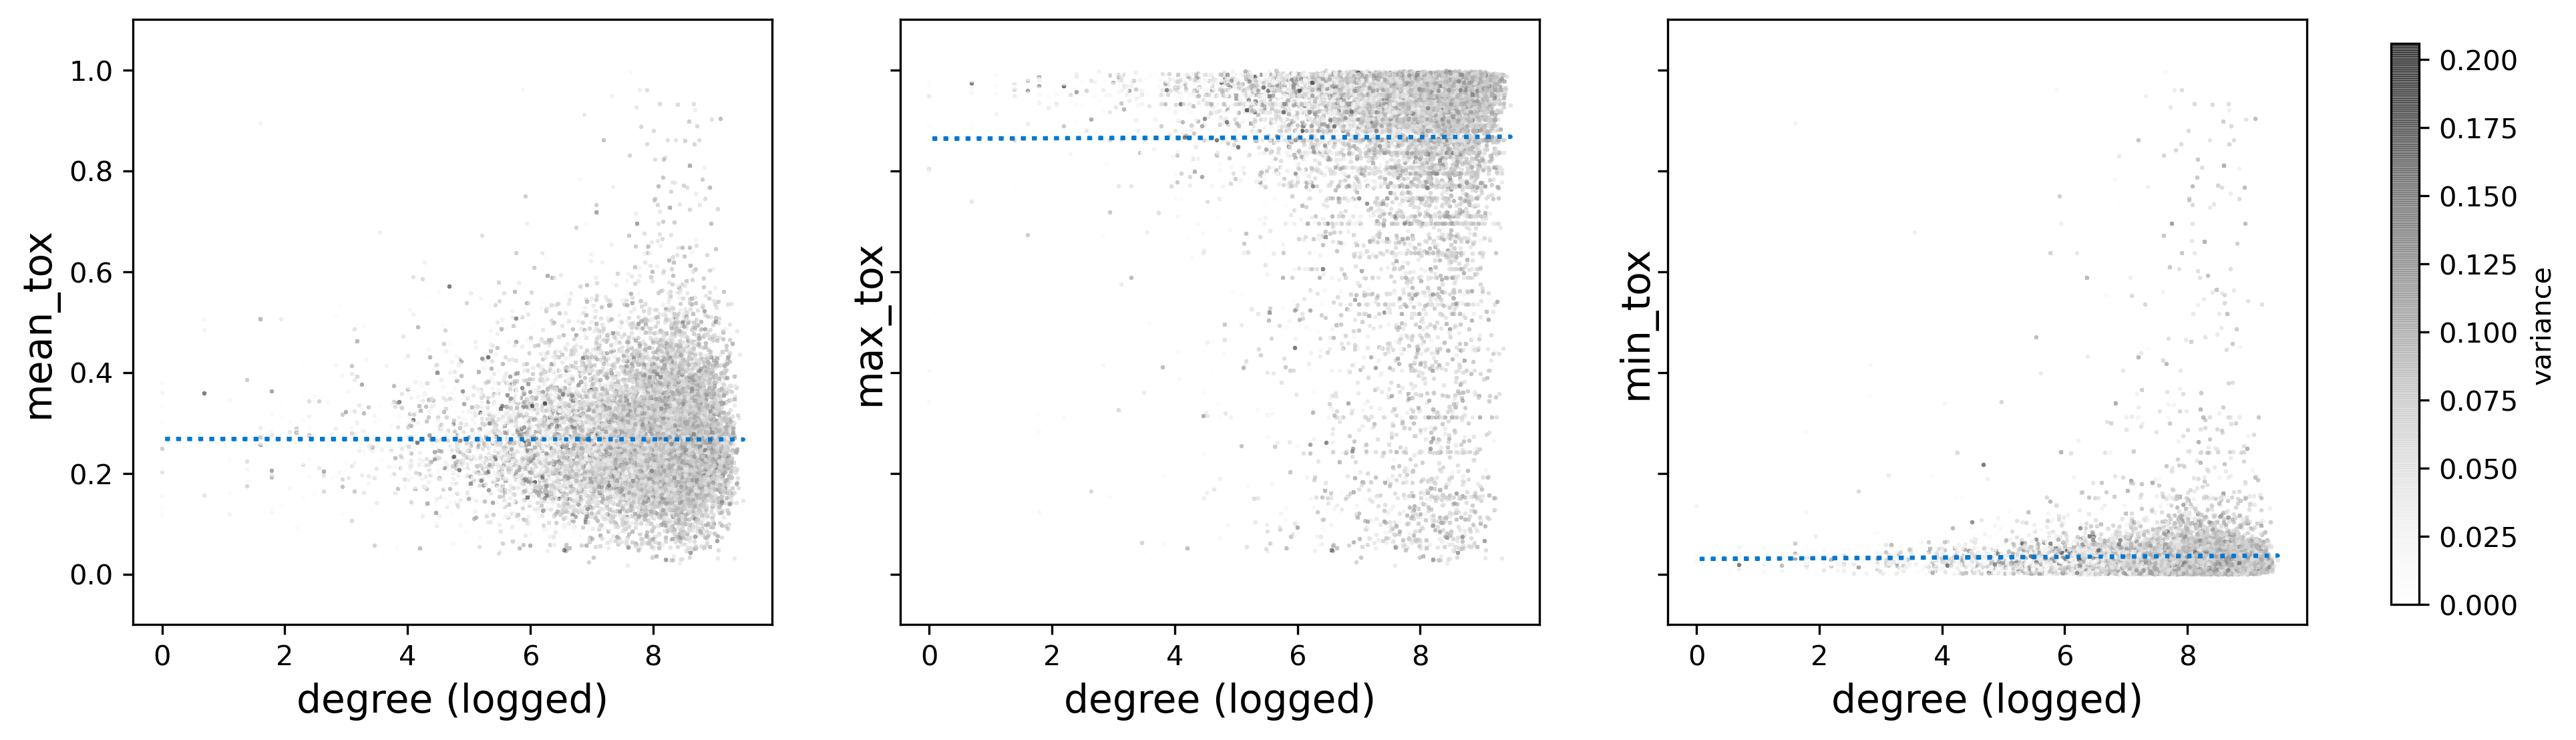

In [101]:
fig, ax = plt.subplots(ncols=3, figsize=(14,4), sharex=True, sharey=True, dpi=300)
for i,col in enumerate(["mean_tox", "max_tox", "min_tox"]):
    filtered_df = nodedf_rd_tox3.dropna(subset=["degree_logged", col])
#     filtered_df = nodedf.dropna(subset=["degree_logged", col])
    x = filtered_df["degree_logged"]
    y = filtered_df[col]

    # scatterplot
    _ = ax[i].scatter(x, y, cmap="Greys", c=filtered_df["var_tox"], alpha=0.6, s=1, marker="+")
    
    # OLS
    m,b = np.polyfit(x, y, 1)
    ax[i].plot(x, m*x+b, ":", color="#0079D3")
    ax[i].set_xlabel("degree (logged)", fontsize=14)
    ax[i].set_ylabel(col, fontsize=14)
    ax[i].set_ylim(-0.1,1.1)
fig.colorbar(_, cax=fig.add_axes([0.93, 0.15, 0.01, 0.7]), label="variance")
plt.savefig(ROOTPATH + f"output/fig/rd_tox3_user_degree_tox_{year}.png", dpi=300)

In [102]:
for col in ["mean_tox", "max_tox", "min_tox"]:
    print("\n\n********* OLS *********")
    print("x = strength")
    print("y =", col, "\n")
    OLS_fit(nodedf_rd_tox3.dropna()["strength_logged"], nodedf_rd_tox3.dropna()[col])



********* OLS *********
x = strength
y = mean_tox 

const              0.267858
strength_logged   -0.000062
dtype: float64
                            OLS Regression Results                            
Dep. Variable:               mean_tox   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.01542
Date:                Wed, 08 Dec 2021   Prob (F-statistic):              0.901
Time:                        11:20:19   Log-Likelihood:                 13011.
No. Observations:               14738   AIC:                        -2.602e+04
Df Residuals:                   14736   BIC:                        -2.600e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-

In [106]:
examine_gfps(userg_rd_tox, nodedf_rd_tox3)

progress: 0.0
progress: 0.06778741865509762
progress: 0.13557483731019523
progress: 0.20336225596529284
progress: 0.27114967462039047
progress: 0.33893709327548804
progress: 0.4067245119305857
progress: 0.4745119305856833
progress: 0.5422993492407809
progress: 0.6100867678958786
progress: 0.6778741865509761
progress: 0.7456616052060737
progress: 0.8134490238611713
progress: 0.881236442516269
progress: 0.9490238611713666


In [111]:
import scipy.stats
filtered_df = nodedf_rd_tox3.dropna(subset=["degree", "strength", "mean_tox"])
x = filtered_df["degree"]
y = filtered_df["mean_tox"]
scipy.stats.pearsonr(x, y)

(0.0046428046129511, 0.5729403987851467)

In [114]:
# average toxicity holding prob
print("H:", np.mean(nodedf_rd_tox3["gfp"]))

H: 0.6170010845986985


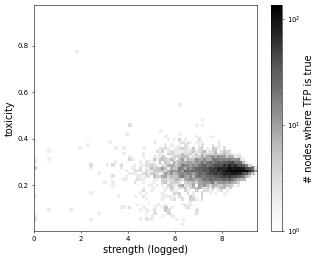

In [139]:
fig, ax = plt.subplots(figsize=(7.2,6), dpi=50)
x = nodedf_rd_tox[nodedf_rd_tox3["gfp"]==1].dropna()["degree_logged"]
y = nodedf_rd_tox[nodedf_rd_tox3["gfp"]==1].dropna()["mean_tox"]
arrs5 = plt.hist2d(x, y, (80,80), norm=mpl.colors.LogNorm(), cmap="Greys")
plt.xlabel("strength (logged)", fontsize=14)
plt.ylabel("toxicity", fontsize=14)
# ax.set_ylim(0,0.6)
plt.colorbar().set_label(label="# nodes where TFP is true",size=14)
# plt.savefig(ROOTPATH + f"output/fig/rd_tox_tfp_true_{year}.png", dpi=300)

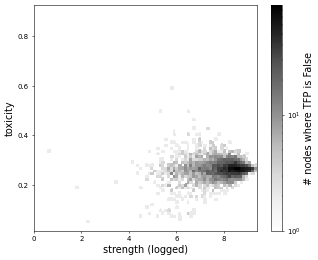

In [140]:
fig, ax = plt.subplots(figsize=(7.2,6), dpi=50)
x = nodedf_rd_tox[nodedf_rd_tox3["gfp"]==0].dropna()["degree_logged"]
y = nodedf_rd_tox[nodedf_rd_tox3["gfp"]==0].dropna()["mean_tox"]
arrs6 = plt.hist2d(x, y, (80,80), norm=mpl.colors.LogNorm(), cmap="Greys")
plt.xlabel("strength (logged)", fontsize=14)
plt.ylabel("toxicity", fontsize=14)
# ax.set_ylim(0,0.6)
plt.colorbar().set_label(label="# nodes where TFP is False",size=14)
# plt.savefig(ROOTPATH + f"output/fig/rd_tox_tfp_true_{year}.png", dpi=300)

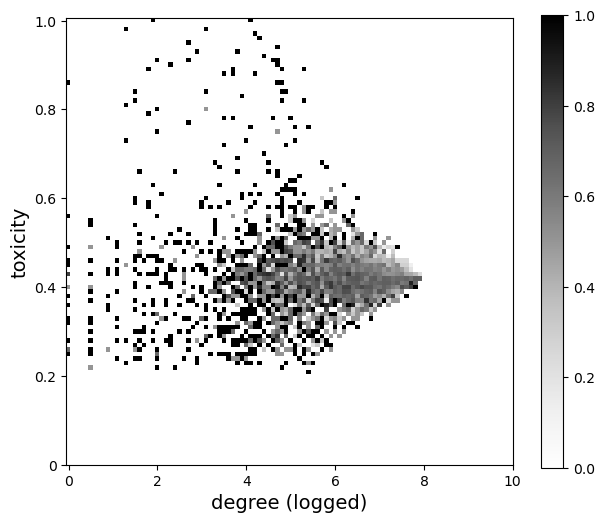

In [141]:
arrs_d = arrs5[0]/(arrs5[0]+arrs6[0])
fig, ax = plt.subplots(figsize=(7.2,6), dpi=100)
plt.imshow(rotate_90_degree_anticlckwise(arrs_d), cmap="Greys")
plt.xticks(np.arange(0,120,20), [0,2,4,6,8,10])
plt.yticks(np.arange(0,120,20), [1.0, 0.8, 0.6, 0.4, 0.2, 0])
plt.xlabel("degree (logged)", fontsize=14)
plt.ylabel("toxicity", fontsize=14)
plt.colorbar()
plt.savefig(ROOTPATH + f"output/fig/tfp_prob_{year}.png", dpi=300)

### generating random toxicity scores

In [104]:
# import random
# df_rd_tox2 = df.copy()
# df_rd_tox2["toxicity"] = [random.random() for i in range(len(df))]

In [103]:
# # get toxicity score for individual users
# aggr_func = {"toxicity": lambda x: list(x)}
# user_toxicity_rd_tox2 = df_rd_tox2[["author","toxicity"]][df_rd_tox2["toxicity"].notna()].groupby("author").agg(aggr_func).reset_index()
# nodedf_rd_tox2 = nodedf_rd_tox[["Id","author","degree","strength","degree_logged","strength_logged"]].copy()
# nodedf_rd_tox2 = nodedf_rd_tox2.merge(user_toxicity_rd_tox2, on="author", how="left")
# nodedf_rd_tox2["mean_tox"] = nodedf_rd_tox2["toxicity"].map(lambda x: np.mean(x))
# nodedf_rd_tox2["max_tox"] = nodedf_rd_tox2["toxicity"].map(lambda x: max(x) if str(x)!="nan" else np.NaN)
# nodedf_rd_tox2["min_tox"] = nodedf_rd_tox2["toxicity"].map(lambda x: min(x) if str(x)!="nan" else np.NaN)
# nodedf_rd_tox2["range_tox"] = nodedf_rd_tox2["toxicity"].map(lambda x: max(x)-min(x) if str(x)!="nan" else np.NaN)
# nodedf_rd_tox2["var_tox"] = nodedf_rd_tox2["toxicity"].map(lambda x: np.var(x) if str(x)!="nan" else np.NaN)

In [89]:
# fig, ax = plt.subplots(ncols=3, figsize=(14,4), sharex=True, sharey=True, dpi=300)
# for i,col in enumerate(["mean_tox", "max_tox", "min_tox"]):
#     filtered_df = nodedf_rd_tox2.dropna(subset=["strength_logged", col])
# #     filtered_df = nodedf.dropna(subset=["degree_logged", col])
#     x = filtered_df["strength_logged"]
#     y = filtered_df[col]

#     # scatterplot
#     _ = ax[i].scatter(x, y, cmap="Greys", c=filtered_df["var_tox"], alpha=0.6, s=1, marker="+")
    
#     # OLS
#     m,b = np.polyfit(x, y, 1)
#     ax[i].plot(x, m*x+b, ":", color="#0079D3")
#     ax[i].set_xlabel("strength (logged)", fontsize=14)
#     ax[i].set_ylabel(col, fontsize=14)
#     ax[i].set_ylim(-0.1,1.1)
# fig.colorbar(_, cax=fig.add_axes([0.93, 0.15, 0.01, 0.7]), label="variance")
# # plt.savefig(ROOTPATH + f"output/fig/rd_tox2_user_strength_tox_{year}.png", dpi=300)

In [105]:
# for col in ["mean_tox", "max_tox", "min_tox"]:
#     print("\n\n********* OLS *********")
#     print("x = strength")
#     print("y =", col, "\n")
#     OLS_fit(nodedf_rd_tox2.dropna()["strength_logged"], nodedf_rd_tox2.dropna()[col])

### shuffling links

In [40]:
userg_conf = nx.configuration_model(degs)  

In [136]:
nodedf["conf_node_id"] = np.arange(len(nodedf))

,Id,author,degree,strength,strength_logged,degree_logged,toxicity,mean_tox,max_tox,min_tox,range_tox,var_tox,gfp,conf_node_id
0,128020,Pendit76,843,1029,6.936343,6.736967,"[0.07150236, 0.113486566, 0.07136423, 0.688616...",0.244354,0.972036,0.020886,0.951150,0.062681,1,0
1,134440,CRYMTYPHON,5822,15727,9.663134,8.669399,"[0.23229153, 0.042700093, 0.50362533, 0.151573...",0.294913,0.932329,0.010667,0.921662,0.045888,0,1
2,99410,IrishJoe,8931,47326,10.764815,9.097284,"[0.5656186, 0.17089713, 0.030456875, 0.0559715...",0.234815,0.990510,0.001658,0.988852,0.049597,1,2
3,63493,willanthony,9326,39162,10.575462,9.140561,"[0.38555548, 0.076418005, 0.10233141, 0.092441...",0.262922,0.960758,0.005846,0.954912,0.065365,1,3
4,4782,1000000students,5113,11822,9.377717,8.539542,"[0.19081137, 0.20994434, 0.27875006, 0.1044623...",0.272007,0.974818,0.000139,0.974679,0.048128,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14747,334626,FistofanAngryGoddess,199,199,5.293305,5.293305,[0.8606264],0.860626,0.860626,0.860626,0.000000,0.000000,0,14747
14748,335449,Mekhami,121,121,4.795791,4.795791,[0.09647358],0.096474,0.096474,0.096474,0.000000,0.000000,1,14748
14749,336202,blaaaahhhhh,309,309,5.733341,5.733341,[0.13698003],0.136980,0.136980,0.136980,0.000000,0.000000,1,14749
14750,337004,tpwoods28,216,216,5.375278,5.375278,[0.18046162],0.180462,0.180462,0.180462,0.000000,0.000000,1,14750


## MISC

In [41]:
# sns.set(rc={"figure.figsize":(8,8)})
# sns.set_style("white")
# x = nodedf[nodedf["gfp"]==1].dropna()["degree_logged"]
# y = nodedf[nodedf["gfp"]==1].dropna()["mean_tox"]
# sns.jointplot(x, y, kind="kde", fill=True, cmap="Blues")  # kde, hex, scatter
# plt.savefig(ROOTPATH + f"output/fig/tfp_{year}.png", dpi=300)